In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from cpyment import CModel
from SEIR_x_UD import seirxud_abm_gill, SEIRxUD

In [3]:
N = 3000
I0 = 0.01
c = 13
beta = 0.018
alpha = 0.2
gamma = 0.0714
theta = 0.1
kappa = 0.03
eta = 1.0
chi = 0.3

R0 = beta*c/gamma
print('R0 = {0}'.format(R0))

R0 = 3.2773109243697474


In [4]:
tmax = 600

params = {
    'c': c,
    'beta': beta,
    'alpha': alpha,
    'gamma': gamma,
    'theta': theta,
    'kappa': kappa,
    'eta': eta,
    'chi': chi
}

model = SEIRxUD(N=N, tmax=tmax, I0=I0, tsteps=1000, **params)

trajsGill = model.run_abm(samples=10)

trajsGillAvg = np.average(trajsGill, axis=0)
trajsGillStd = np.std(trajsGill, axis=0)

2020-05-01 09:28:41,402 - INFO - Sampling trajectory 1/10
2020-05-01 09:28:48,703 - INFO - Sampling trajectory 2/10
2020-05-01 09:28:49,090 - INFO - Sampling trajectory 3/10
2020-05-01 09:28:49,367 - INFO - Sampling trajectory 4/10
2020-05-01 09:28:49,668 - INFO - Sampling trajectory 5/10
2020-05-01 09:28:50,027 - INFO - Sampling trajectory 6/10
2020-05-01 09:28:50,232 - INFO - Sampling trajectory 7/10
2020-05-01 09:28:50,448 - INFO - Sampling trajectory 8/10
2020-05-01 09:28:50,864 - INFO - Sampling trajectory 9/10
2020-05-01 09:28:51,096 - INFO - Sampling trajectory 10/10


In [7]:
t0i = 0
delay = model.t[t0i]
traj = model.run_cmodel(t0=delay, y0=np.concatenate([trajsGillAvg[:8,t0i], [0, 0, 0, 0]]), etadamp=1, 
                        has_memory_states=True)
traj = model.run_cmodel(t0=delay, y0=trajsGillAvg[:8,t0i], etadamp=1)
trajNoCT = model.run_cmodel(etadamp=0)

logI = np.log(traj["y"][:,4] + traj["y"][:,5])
grate = (logI[1:] - logI[:-1])/(model.t[1] - model.t[0])
repro = np.exp(grate/gamma)

logINoCT = np.log(trajNoCT["y"][:,4] + trajNoCT["y"][:,5])
grateNoCT = (logINoCT[1:] - logINoCT[:-1])/(model.t[1] - model.t[0])
reproNoCT = np.exp(grateNoCT/gamma)

print("Max Re = {0}, Max Re (No CT) = {1}".format(np.max(repro), np.max(reproNoCT)))

Max Re = 1.5054507955937857, Max Re (No CT) = 1.8378981979487368


<IPython.core.display.Javascript object>


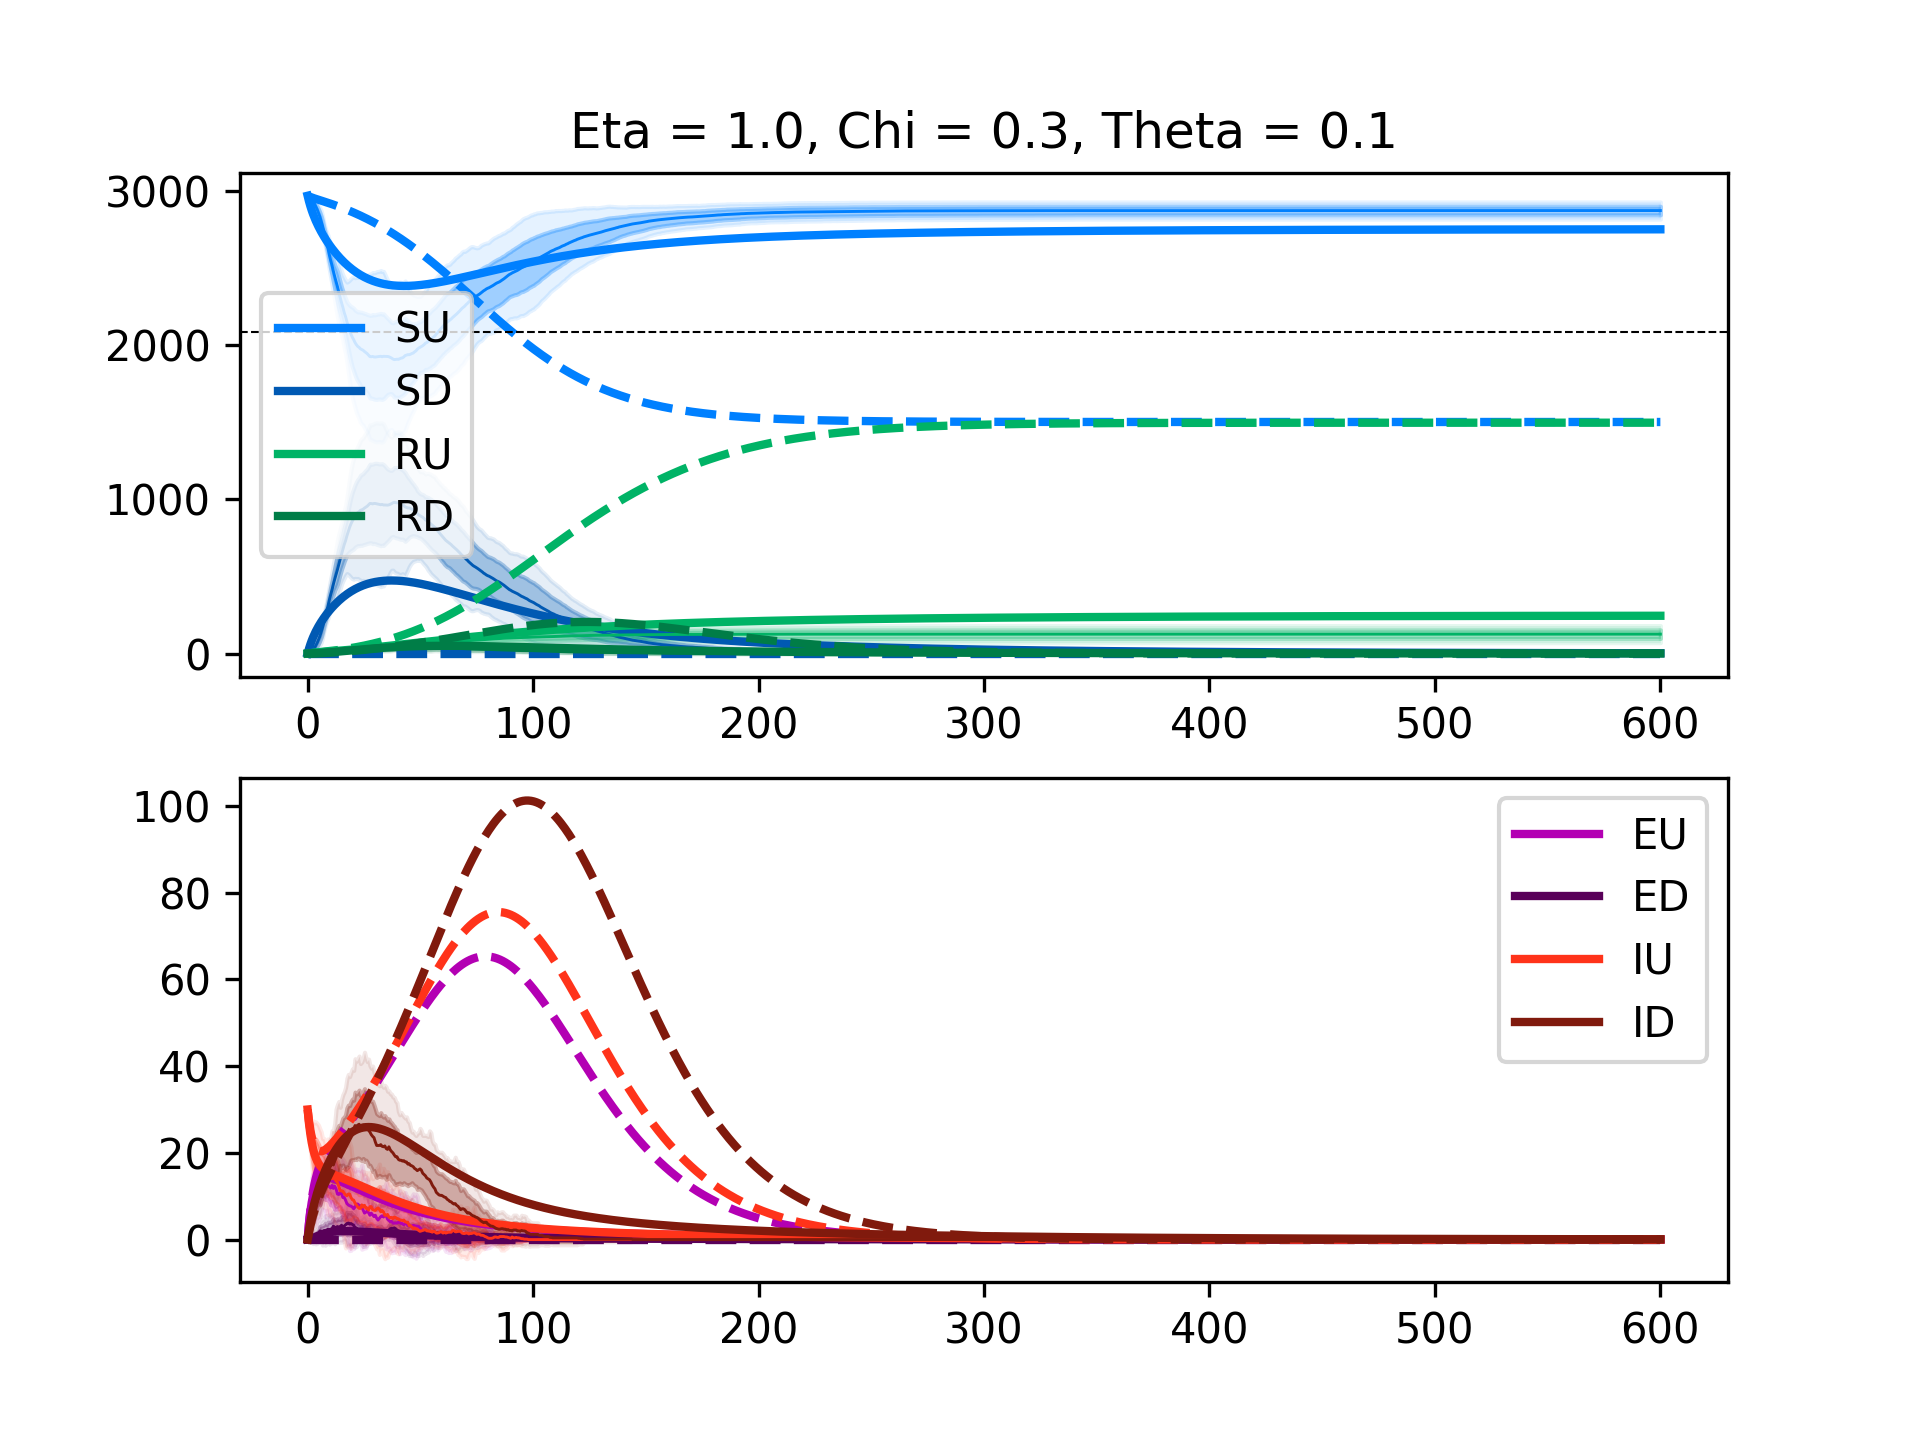

In [8]:
fig, (ax1, ax2) = plt.subplots(2, dpi=150)
t = model.t.copy()

colors = {
    'S': np.array((0.0, 0.5, 1.0)),
    'E': np.array((0.7, 0.0, 0.7)),
    'I': np.array((1.0, 0.2, 0.1)),
    'R': np.array((0.0, 0.7, 0.4)),
}


ax1.set_title('Eta = {0}, Chi = {1}, Theta = {2}'.format(eta, chi, theta))

#ax.set_xlim(0,t[10])
#ax.set_ylim(-1, 15)
stdn = 1

for (i,s) in ((0, 'S'), (3, 'R')):
    for j, d in enumerate('UD'):
        col = colors[s]*(1 if j == 0 else 0.7)
        ax1.plot(t[t0i:], traj['y'][:,2*i+j], c=col, label=s+d, lw=2.0)
        ax1.plot(t, trajNoCT['y'][:,2*i+j], c=col, lw=2.0, ls='--')
        ax1.plot(t, trajsGillAvg[2*i+j], c=col, lw=0.7)
        ax1.fill_between(t, 
                        trajsGillAvg[2*i+j]+2*stdn*trajsGillStd[2*i+j], 
                        trajsGillAvg[2*i+j]-2*stdn*trajsGillStd[2*i+j], 
                        color=list(col) + [0.1])
        ax1.fill_between(t, 
                        trajsGillAvg[2*i+j]+stdn*trajsGillStd[2*i+j], 
                        trajsGillAvg[2*i+j]-stdn*trajsGillStd[2*i+j], 
                        color=list(col) + [0.3])
    
ax1.axhline((1-1/R0)*N, c=(0,0,0), lw=0.5, ls='--')
ax1.legend()

for (i,s) in ((1, 'E'), (2, 'I')):
    for j, d in enumerate('UD'):
        col = colors[s]*(1 if j == 0 else 0.5)
        ax2.plot(t[t0i:], traj['y'][:,2*i+j], c=col, label=s+d, lw=2.0)
        ax2.plot(t, trajNoCT['y'][:,2*i+j], c=col, lw=2.0, ls='--')
        ax2.plot(t, trajsGillAvg[2*i+j], c=col, lw=0.7)
        ax2.fill_between(t, 
                        trajsGillAvg[2*i+j]+2*stdn*trajsGillStd[2*i+j], 
                        trajsGillAvg[2*i+j]-2*stdn*trajsGillStd[2*i+j], 
                        color=list(col) + [0.1])
        ax2.fill_between(t, 
                        trajsGillAvg[2*i+j]+stdn*trajsGillStd[2*i+j], 
                        trajsGillAvg[2*i+j]-stdn*trajsGillStd[2*i+j], 
                        color=list(col) + [0.3])
    
#ax2.axhline((1-1/R0)*N, c=(0,0,0), lw=0.5, ls='--')
ax2.legend()

<IPython.core.display.Javascript object>


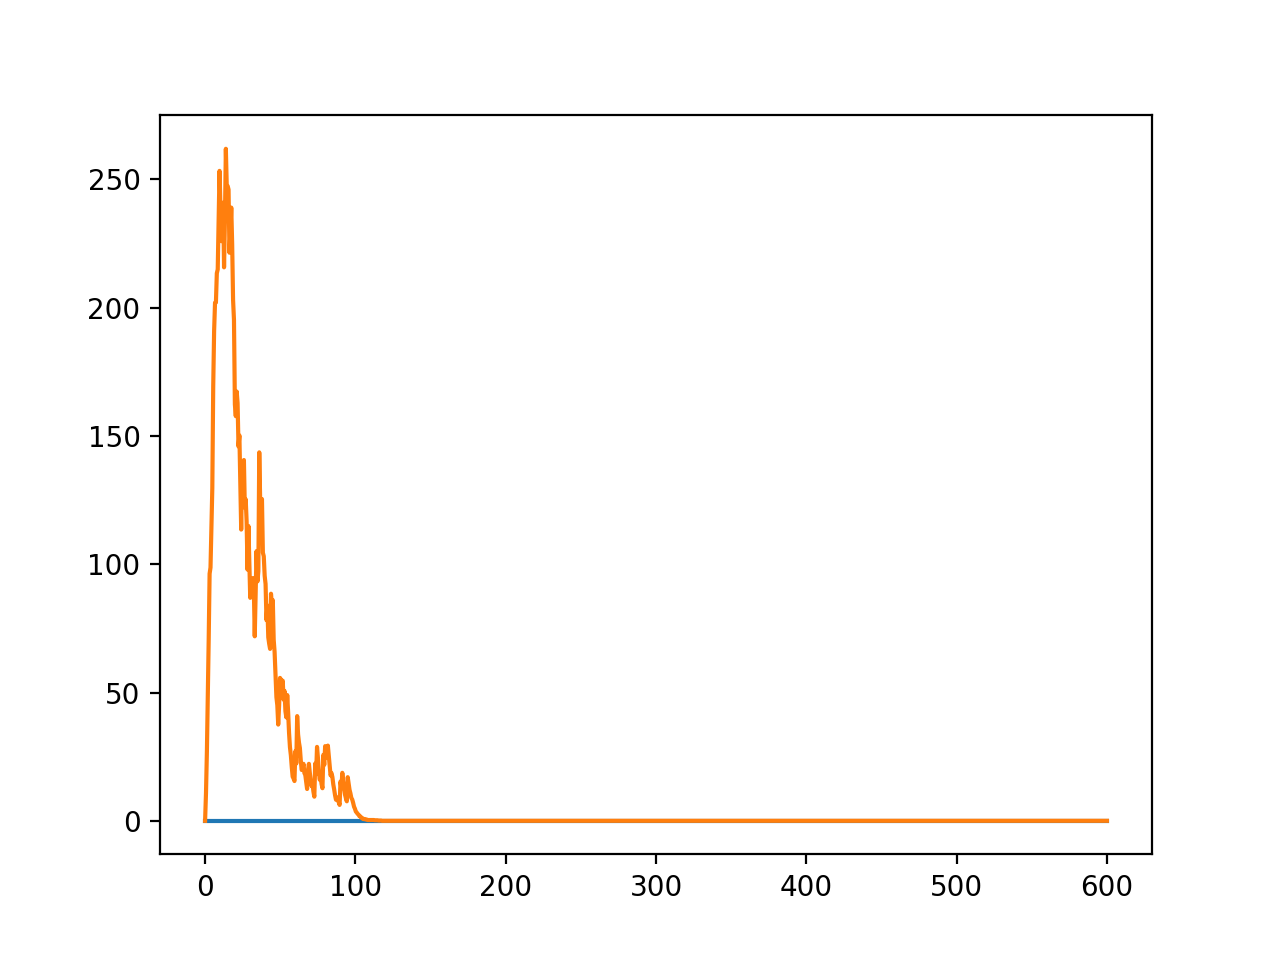

In [9]:
fig, ax = plt.subplots()

ax.plot(model.t, np.sum(traj['y'][:,8:], axis=1)*eta*theta)
ax.plot(model.t, trajsGillAvg[8])

In [10]:
fig, ax = plt.subplots()

ax.plot(model.t, traj['y'][:,8])

<IPython.core.display.Javascript object>

IndexError: index 8 is out of bounds for axis 1 with size 8

In [ ]:
# Total fraction of diagnosed people

fig, ax = plt.subplots()

ax.set_title('Percentage of diagnosed people')

ax.set_xlabel('t')
ax.set_ylabel('*D (%)')

ax.plot(t[t0i:], np.sum(traj['y'][:,1::2], axis=1)*100/N, label='ODE')
ax.plot(t, np.sum(trajsGillAvg[1::2], axis=0)*100/N, label='ABM')

ax.legend()

In [ ]:
from scipy.integrate import odeint

In [ ]:
# Nonlinear version
def ode_nonlin(y, t, N=1000,
                     beta=0.05,
                     alpha=0.2,
                     gamma=0.1,
                     theta=0.0,
                     kappa=0.05,
                     eta=0,
                     chi=0):
    dydt = y*0
    SU, SD, EU, ED, IU, ID, RU, RD = y
    
    pCI = 1-(1-theta*IU/N)**(c/gamma)
    dSUEU = beta*c/N*SU*IU
    dSUSD = chi*eta*(1-beta)*pCI*SU
    dSDSU = kappa*SD
    dEUIU = alpha*EU
    dEUED = eta*chi*theta*EU
    dEDID = alpha*ED
    dIUID = theta*(1+eta*chi)*IU
    dIURU = gamma*IU
    dIDRD = gamma*ID
    dRURD = chi*eta*pCI*RU
    dRDRU = kappa*RD
    
    dydt[0] = -dSUEU-dSUSD + dSDSU
    dydt[1] = dSUSD-dSDSU
    dydt[2] = dSUEU-dEUIU-dEUED
    dydt[3] = dEUED-dEDID
    dydt[4] = dEUIU-dIUID-dIURU
    dydt[5] = dEDID+dIUID-dIDRD
    dydt[6] = dIURU-dRURD+dRDRU
    dydt[7] = dIDRD-dRDRU+dRURD
    
    return dydt

In [ ]:
y0 = np.zeros(8)
y0[0] = N*(1-I0)
y0[4] = N*I0
sol = odeint(ode_nonlin, y0, model.t, args=(N, beta, alpha, gamma, theta, kappa, eta, chi))

In [ ]:
fig, ax = plt.subplots()

ax.plot(model.t, sol)
ax.plot(model.t, traj['y'])

In [ ]:
from numba import jit

In [ ]:
@jit(nopython=True)
def testf(n):
    return np.zeros(n, dtype=np.bool8)

In [ ]:
testf(4)